<a href="https://colab.research.google.com/github/Garaujott/Projeto_SirioLibanes_Covid_Kaggle/blob/main/ProjetoSirioLibanes_PreparacaoDados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparação do Ambiente e Observações

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Importação dos dados

In [2]:
# base presente no Kaggle (https://www.kaggle.com/S%C3%ADrio-Libanes/covid19)

uri = 'https://github.com/Garaujott/Projeto_SirioLibanes_Covid_Kaggle/blob/main/dados/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true'

covid = pd.read_excel(uri)
covid.head(10)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.339130,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.4075

# Análise Exploratória e Pré-processamento dos Dados

## Análise Preliminar

In [3]:
covid.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1925.000000,1925.000000,1925.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,...,821.000000,821.000000,821.0,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1925.000000
mean,192.000000,0.467532,0.368831,0.108333,0.028125,0.097917,0.019792,0.128125,0.046875,0.213021,0.158333,0.809896,0.528527,0.528527,0.528527,0.528527,-1.0,-0.963433,-0.963433,-0.963433,-0.963433,-1.0,-0.931121,-0.931121,-0.931121,-0.931121,-1.0,-0.310924,-0.310924,-0.310924,-0.310924,-1.0,-0.311845,-0.311845,-0.311845,-0.311845,-1.0,-0.945928,-0.945928,-0.945928,...,-0.954177,-0.954177,-1.0,-0.093631,-0.332600,-0.264701,-0.438754,0.066893,0.743077,-0.097790,-0.338468,-0.268632,-0.435121,0.063798,0.748588,-0.040855,-0.207812,-0.264999,-0.483129,0.326823,0.817565,-0.235001,-0.399582,-0.282029,-0.316753,0.014964,0.818593,-0.752454,-0.728053,-0.754100,-0.703683,-0.770338,-0.887196,-0.786997,-0.715950,-0.817800,-0.719147,-0.771327,-0.886982,0.267532
std,111.168431,0.499074,0.482613,0.310882,0.165373,0.297279,0.139320,0.334316,0.211426,0.409549,0.365148,0.392485,0.224100,0.224100,0.224100,0.224100,0.0,0.160870,0.160870,0.160870,0.160870,0.0,0.169509,0.169509,0.169509,0.169509,0.0,0.100256,0.100256,0.100256,0.100256,0.0,0.118812,0.118812,0.118812,0.118812,0.0,0.076610,0.076610,0.076610,...,0.123582,0.123582,0.0,0.252064,0.274102,0.246760,0.217113,0.242858,0.132635,0.257733,0.277952,0.252709,0.225554,0.249208,0.125994,0.281304,0.277802,0.272725,0.278239,0.216198,0.283453,0.271123,0.287580,0.296247,0.402675,0.276163,0.141316,0.364001,0.408677,0.366349,0.482097,0.319001,0.296147,0.324754,0.419103,0.270217,0.446600,0.317694,0.296772,0.442787
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000

Avaliando a estrutura da base: as linhas representam as visitas/avaliações dos pacientes em cada uma das 5 janelas possíveis. Veja que a variável *PATIENT_VISIT_IDENTIFIER* repete os valores de 5 em 5 linhas, enquanto a janelas de atendimento ('WINDOW') segue uma ordem determinada.

In [4]:
covid[['PATIENT_VISIT_IDENTIFIER', 'WINDOW']].head(15)

,PATIENT_VISIT_IDENTIFIER,WINDOW
0,0,0-2
1,0,2-4
2,0,4-6
3,0,6-12
4,0,ABOVE_12
5,1,0-2
6,1,2-4
7,1,4-6
8,1,6-12
9,1,ABOVE_12


A variável *PATIENT_VISIT_IDENTIFIER* é o código de identificação do paciente, esse código está entre 0 e 384. Isso significa que temos 385 pacientes na base, que foram avaliados 5 vezes, resultando nas 1925 linhas da tabela.

In [5]:
# a base tem 385 indivíduos, mas eles aparecem 5 vezes cada. Por isso, que temos mais de 385 observações.

print(f'A base tem {len(covid["PATIENT_VISIT_IDENTIFIER"].unique())} indivíduos.')

A base tem 385 indivíduos.


## Limpeza dos Dados

### Lidando com dados missing

In [6]:
covid.head(10)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.339130,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.4075

Como a base contém dados de cada avaliação pela qual o paciente foi submetido, podem haver exames não realizados em determinados períodos. Isso resulta em apenas 6 variáveis completamente preenchidas, sendo as demais com, no minímo, 685 linhas sem dados preenchidos.

In [7]:
covid.isna().sum().value_counts(sort = False)

0         6
5         9
1104    180
685      18
748       6
694       6
686       6
dtype: int64

Podemos considerar os métodos backfill e forwardfill para preenchermos os dados faltantes. Isso porque nesse contexto, com janelas curtas, a variação dos dados dos sinais vitais e dos exames tende a ser baixa. De forma que para o nosso objetivo de classificar possíveis pacientes que podem necessitar de uma UTI, essa é uma suposição válida. Em outras situações, essa abordagem poderia não ser razoável.

In [8]:
def fill_NAs(dados):
  features_continuas_colunas = dados.iloc[:, 13:-2].columns
  features_continuas = dados.groupby(by = 'PATIENT_VISIT_IDENTIFIER', as_index = False)[features_continuas_colunas].fillna(method = 'bfill').fillna(method = 'ffill')
  features_categoricas = dados.iloc[:, :13]
  saida = dados.iloc[:, -2:]
  dados_finais = pd.concat([features_categoricas, features_continuas, saida], ignore_index = True, axis = 1)
  dados_finais.columns = dados.columns # nomeando colunas da tabela manipulada
  return dados_finais

In [9]:
covid_limpo = fill_NAs(covid)
covid_limpo.head(10)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.272727,-0.275362,0.736842,-0.339130,0.325153,0.114504,0.176471,-1.000000,-1.000000,-0.389967,0.407558,-0.230462,0.096774,-1.000000,-1.000000,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.27

Ignorando pacientes não tinham dados incluídos:

In [10]:
covid_limpo = covid_limpo.dropna() # pacientes sem dado algum

Como pacientes que foram encaminhados para a UTI logo no primeiro atendimento não agregam informações ao modelo, iremos removê-los:

In [11]:
# excluir pacientes que deram entrada na UTI logo na primeira janela (0-2)

pacientes_a_remover = covid_limpo.query('WINDOW == "0-2" & ICU == 1')['PATIENT_VISIT_IDENTIFIER'].values
covid_limpo = covid_limpo.query('PATIENT_VISIT_IDENTIFIER not in @pacientes_a_remover')
covid_limpo.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1760.000000,1760.000000,1760.000000,1760.00000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,...,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000
mean,192.818182,0.457386,0.380682,0.11250,0.026136,0.101705,0.021591,0.132955,0.049432,0.212500,0.163636,0.828977,0.517913,0.517913,0.517913,0.517913,-1.0,-0.958386,-0.958386,-0.958386,-0.958386,-1.0,-0.926916,-0.926916,-0.926916,-0.926916,-1.0,-0.306430,-0.306430,-0.306430,-0.306430,-1.0,-0.305377,-0.305377,-0.305377,-0.305377,-1.0,-0.945935,-0.945935,-0.945935,...,-0.955277,-0.955277,-1.0,-0.073908,-0.339631,-0.267838,-0.458545,0.067973,0.747996,-0.078023,-0.344698,-0.270867,-0.452606,0.064864,0.751914,-0.001207,-0.187010,-0.243988,-0.469278,0.350887,0.841908,-0.248728,-0.432592,-0.313034,-0.381784,-0.017968,0.808029,-0.799862,-0.785938,-0.804580,-0.778209,-0.823458,-0.915593,-0.828593,-0.774857,-0.854690,-0.788155,-0.824412,-0.915552,0.201705
std,110.637724,0.498322,0.485692,0.31607,0.159586,0.302345,0.145385,0.339622,0.216829,0.409193,0.370050,0.376636,0.235219,0.235219,0.235219,0.235219,0.0,0.182797,0.182797,0.182797,0.182797,0.0,0.178947,0.178947,0.178947,0.178947,0.0,0.107783,0.107783,0.107783,0.107783,0.0,0.120988,0.120988,0.120988,0.120988,0.0,0.088861,0.088861,0.088861,...,0.125227,0.125227,0.0,0.248552,0.261409,0.241648,0.207736,0.239760,0.119912,0.254493,0.264516,0.247132,0.218765,0.247949,0.119985,0.270201,0.261183,0.260190,0.252147,0.193029,0.236797,0.246389,0.258776,0.274449,0.356890,0.262440,0.132323,0.322680,0.356078,0.324716,0.411909,0.276279,0.247695,0.287696,0.368311,0.240338,0.384405,0.274953,0.248093,0.401387
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

Verificando se o paciente foi encaminhado à UTI em alguma janela. Esse passo é importante para a consolidação da variável 'ICU'. Utilizamos como base para essa variável a janela '0-2', pois queremos classificar se o paciente vai precisar ou não de uma UTI o mais cedo possível, ou seja, na primeira janela.

In [12]:
# verificando se o paciente foi encaminhado à UTI
# documentação loc-pandas: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html
# documentação any-numpy: https://numpy.org/doc/stable/reference/generated/numpy.any.html

def prepare_window(rows):
  if (np.any(rows['ICU'] == 1)):
    rows.loc[rows['WINDOW'] == '0-2', 'ICU'] = 1 # marca se o paciente foi encaminhado à UTI 
                                                 # (independentemente da janela, ainda que marque na 0-2)
  
  return rows.loc[rows['WINDOW'] == '0-2']

covid_limpo = covid_limpo.groupby(by = 'PATIENT_VISIT_IDENTIFIER').apply(prepare_window)

In [13]:
# note que o resultado para WINDOW é sempre '0-2', isso acontece pela forma que construimos a base
covid_limpo['WINDOW'].value_counts()

0-2    352
Name: WINDOW, dtype: int64

Mais um ajuste necessário: durante o processo de anonimização dos dados, a idade foi transformada em uma variável categórica, na qual cada categoria é um percentil em função da distribuição da idade dos paciente. Isto é, se o paciente está no primeiro percentil significa que ele faz parte do grupo dos 10% mais jovens da base.

Utilizando os recursos do pandas para a criação e manipulação de categorias:

In [14]:
# transformação dos dados de AGE_PERCENTIL em dados categóricos
covid_limpo.AGE_PERCENTIL = covid_limpo.AGE_PERCENTIL.astype('category').cat.codes

In [15]:
# úlitmo ajuste em relação aos índices da base
covid_limpo.reset_index(drop = True, inplace = True)

## Algumas informações finais que podem ser de interesse nos próximos passos...

**Dos 352 indivíduos finais da base, quantos foram encaminhados a uma UTI?**
163 pacientes foram encaminhados para a UTI.

In [16]:
covid_limpo['ICU'].value_counts()

0    189
1    163
Name: ICU, dtype: int64

Dada a proporção 53/46 da base, podemos considerar que os dados são balanceados.

In [17]:
covid_limpo['ICU'].value_counts(normalize = True)

0    0.536932
1    0.463068
Name: ICU, dtype: float64

**Quantos indivíduos possuem alguma comorbidade? (352 - 265 = 87)**

87 indivíduos tem alguma comorbidade.

In [18]:
covid_limpo[['DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3', 'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6']].value_counts()

DISEASE GROUPING 1  DISEASE GROUPING 2  DISEASE GROUPING 3  DISEASE GROUPING 4  DISEASE GROUPING 5  DISEASE GROUPING 6
0.0                 0.0                 0.0                 0.0                 0.0                 0.0                   265
                                                                                1.0                 0.0                    19
1.0                 0.0                 0.0                 0.0                 0.0                 0.0                    12
0.0                 0.0                 1.0                 0.0                 0.0                 0.0                    10
1.0                 0.0                 0.0                 0.0                 1.0                 0.0                     9
0.0                 0.0                 0.0                 0.0                 0.0                 1.0                     4
                                        1.0                 0.0                 1.0                 0.0                     4

**Vendo como a distribuição de idade dos pacientes:**

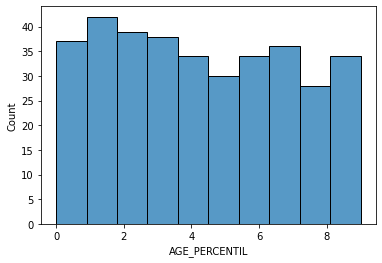

In [19]:
sns.histplot(data = covid_limpo['AGE_PERCENTIL'], stat = 'count', bins = 10)

A distribuição das idades é aproximadamente uniforme.

**Por fim, quantos pacientes tem mais de 65 anos? E quantos desses foram internados?**

161 pacientes dos nossos dados tem mais de 65 anos, sendo que 62% deles foram internados.

Vale ressaltar aqui esse percentual não é muito distante do percentual dos pacientes abaixo de 65 anos. Sabendo que o grupo etário dos idosos (65 anos ou mais) tem [maior risco de hospitalização e óbito](https://www.cdc.gov/mmwr/volumes/69/wr/mm6912e2.htm) e no entanto isso não ser retratado nos dados, é algo que deve ser investigado.

In [20]:
covid_limpo['AGE_ABOVE65'].value_counts()

0    191
1    161
Name: AGE_ABOVE65, dtype: int64

In [21]:
covid_limpo.query('AGE_ABOVE65 == 0')[['AGE_ABOVE65', 'ICU']].value_counts(normalize = True)

AGE_ABOVE65  ICU
0            0      0.670157
             1      0.329843
dtype: float64

In [22]:
covid_limpo.query('AGE_ABOVE65 == 1')[['AGE_ABOVE65', 'ICU']].value_counts(normalize = True)

AGE_ABOVE65  ICU
1            1      0.621118
             0      0.378882
dtype: float64

## Exportar a base pronta para ser utilizada no desenvolvimento do modelo

In [23]:
covid_limpo.to_csv('Sirio_ICU_cleaned.csv', index = False)